In [1]:
import os, sys, json, time, random, shutil

DATA_PATH = "/content/ReadyToTrain_data_2col_with_subjectivity_final.tsv"
OUT_DIR = "/content/project_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

NROWS = 300000
FORCE_TRAIN = False
TARGET_ACC_STEP1 = 0.80
TARGET_ACC_STEP2 = 0.85

print(f"Data Path: {DATA_PATH}")
print(f"Output Directory: {OUT_DIR}")
print(f"Max Rows Loaded: {NROWS}")
print("---")

Data Path: /content/ReadyToTrain_data_2col_with_subjectivity_final.tsv
Output Directory: /content/project_artifacts
Max Rows Loaded: 300000
---


In [2]:
import numpy as np
import tensorflow as tf

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)

In [3]:
import platform
import psutil
import multiprocessing

def get_system_specs():
    print("="*45)
    print("ENVIRONMENT & HARDWARE SPECS")
    print("="*45)
    print(f"Python Version: {sys.version.split()[0]}")
    print(f"TensorFlow Version: {tf.__version__}")
    print(f"OS: {platform.system()} {platform.release()}")

    print(f"CPU Count: {multiprocessing.cpu_count()}")
    ram_info = psutil.virtual_memory()
    print(f"Total RAM: {ram_info.total / (1024**3):.2f} GB")

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"GPU Detected: {len(gpus)} device(s)")
        try:
            gpu_name = !nvidia-smi --query-gpu=name --format=csv,noheader
            print(f"GPU Name: {gpu_name[0]}")
            gpu_mem = !nvidia-smi --query-gpu=memory.total --format=csv,noheader
            print(f"GPU Memory: {gpu_mem[0]}")
        except Exception:
             print("(Specific GPU details unavailable via shell command)")
    else:
        print("GPU: None (Training will be on CPU)")
    print("="*45)

get_system_specs()

ENVIRONMENT & HARDWARE SPECS
Python Version: 3.12.12
TensorFlow Version: 2.19.0
OS: Linux 6.6.105+
CPU Count: 2
Total RAM: 12.67 GB
GPU Detected: 1 device(s)
GPU Name: Tesla T4
GPU Memory: 15360 MiB


In [4]:
import pandas as pd

df_raw = pd.read_csv(DATA_PATH, sep='\t', header=0, encoding='utf-8', nrows=NROWS)
print("Loaded raw data shape:", df_raw.shape)

def infer_columns(df):
    text_col=None; label_col=None
    text_candidates = ['text','content','review','studentcomments','comment','comments','studentcomment']
    for c in df.columns:
        if c.lower() in text_candidates:
            text_col=c; break
    label_candidates = ['label','target','class','sentiment','subjectivity','sentiment_label']
    for c in df.columns:
        if c.lower() in label_candidates:
            label_col=c; break
    if text_col is None: text_col=df.columns[0]
    if label_col is None: label_col=df.columns[1] if len(df.columns)>1 else df.columns[-1]
    return text_col, label_col

TEXT_COL, LABEL_COL = infer_columns(df_raw)
print("Inferred TEXT_COL:", TEXT_COL, "LABEL_COL:", LABEL_COL)

df = df_raw[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)
counts = df[LABEL_COL].value_counts()
print("\nCleaned data shape:", df.shape)
print("Original class counts:\n", counts)

Loaded raw data shape: (300000, 9)
Inferred TEXT_COL: StudentComments LABEL_COL: Sentiment

Cleaned data shape: (300000, 2)
Original class counts:
 Sentiment
positive    251392
negative     26347
neutral      22261
Name: count, dtype: int64


/tmp/ipython-input-1038051815.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette='crest')


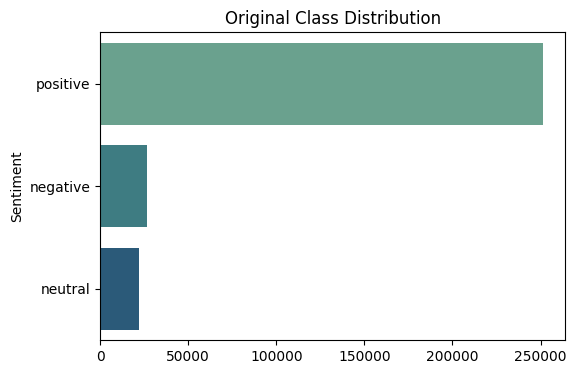

Max text length (words): 205


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = df[LABEL_COL].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=counts.values, y=counts.index, palette='crest')
plt.title("Original Class Distribution")
plt.show()

df['text_len'] = df[TEXT_COL].astype(str).apply(lambda s: len(str(s).split()))
print(f"Max text length (words): {df['text_len'].max()}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Generating WordClouds by Class...


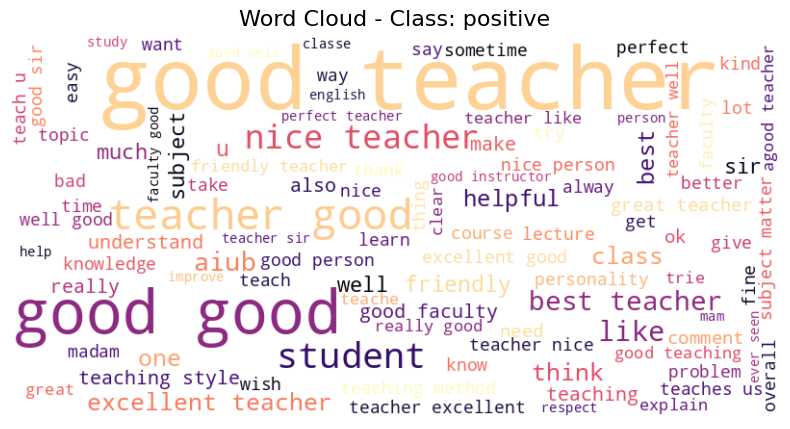

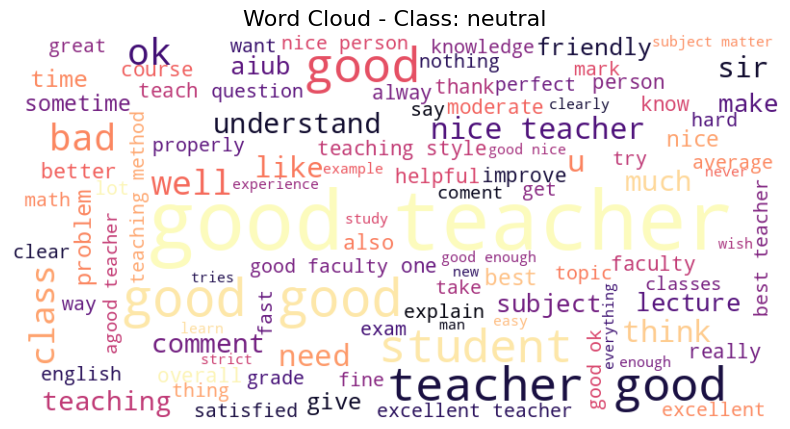

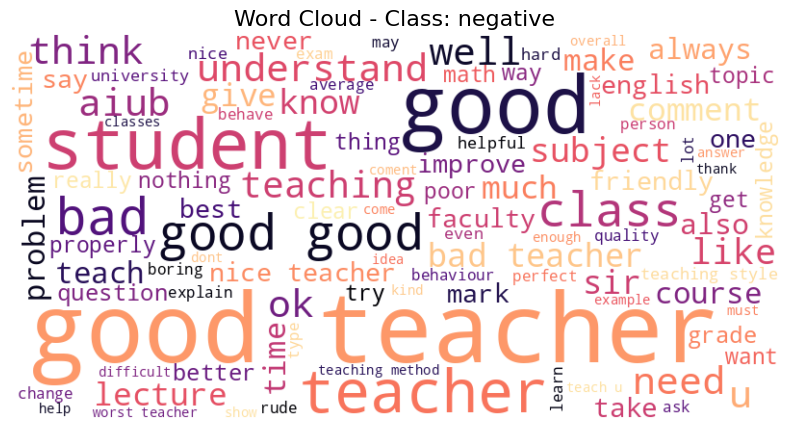

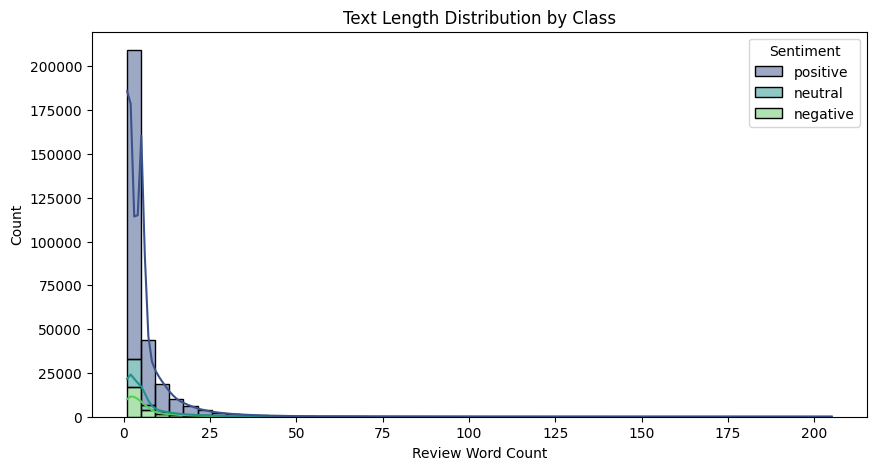

In [7]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))

def plot_word_cloud(text_data, title):
    all_text = ' '.join([str(t) for t in text_data if pd.notna(t)])

    if not all_text:
        print(f"Skipping WordCloud for '{title}' - no valid text data.")
        return

    wc = WordCloud(width=800, height=400, background_color='white',
                   max_words=100, stopwords=STOPWORDS, colormap='magma').generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {title}", fontsize=16)
    plt.show()

print("\nGenerating WordClouds by Class...")
for label in df[LABEL_COL].unique():
    subset = df[df[LABEL_COL] == label][TEXT_COL]
    plot_word_cloud(subset, f"Class: {label}")

plt.figure(figsize=(10, 5))
sns.histplot(df, x='text_len', hue=LABEL_COL, kde=True, bins=50, palette='viridis', multiple='stack')
plt.title("Text Length Distribution by Class")
plt.xlabel("Review Word Count")
plt.show()


Handling Class Imbalance...
Majority class size: 251392
Class 'positive' is majority/balanced, size 251392
Upsampled 'neutral' from 22261 to 251392
Upsampled 'negative' from 26347 to 251392

Final Balanced Data Shape: (754176, 3)
Final Class Counts:
 Sentiment
negative    251392
positive    251392
neutral     251392
Name: count, dtype: int64


/tmp/ipython-input-4047621582.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_balanced[LABEL_COL].value_counts().values, y=df_balanced[LABEL_COL].value_counts().index, palette='icefire')


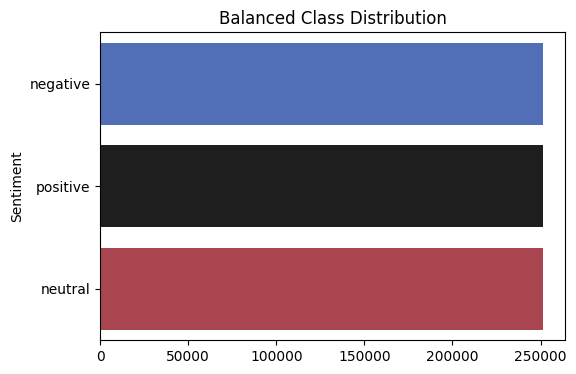

In [8]:
from sklearn.utils import resample

print("\nHandling Class Imbalance...")
majority_size = df[LABEL_COL].value_counts().max()
print(f"Majority class size: {majority_size}")

df_upsampled = []
for label in df[LABEL_COL].unique():
    df_subset = df[df[LABEL_COL] == label]

    if len(df_subset) < majority_size:
        df_resampled = resample(df_subset,
                                replace=True,
                                n_samples=majority_size,
                                random_state=42)
        df_upsampled.append(df_resampled)
        print(f"Upsampled '{label}' from {len(df_subset)} to {majority_size}")
    else:
        df_upsampled.append(df_subset)
        print(f"Class '{label}' is majority/balanced, size {len(df_subset)}")

df_balanced = pd.concat(df_upsampled).sample(frac=1, random_state=42).reset_index(drop=True)
print("\nFinal Balanced Data Shape:", df_balanced.shape)
print("Final Class Counts:\n", df_balanced[LABEL_COL].value_counts())

plt.figure(figsize=(6,4))
sns.barplot(x=df_balanced[LABEL_COL].value_counts().values, y=df_balanced[LABEL_COL].value_counts().index, palette='icefire')
plt.title("Balanced Class Distribution")
plt.show()

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

le = LabelEncoder()
y_encoded = le.fit_transform(df_balanced[LABEL_COL])
y_categorical = to_categorical(y_encoded)
classes = le.classes_
NUM_CLASSES = len(classes)
print(f"Classes: {classes}, Num Classes: {NUM_CLASSES}")

label_map = {i: c for i, c in enumerate(classes)}
with open(os.path.join(OUT_DIR, "label_map.json"), "w", encoding="utf-8") as f:
    json.dump(label_map, f, indent=4)
print(f"Label map saved to {OUT_DIR}/label_map.json")

X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_balanced[TEXT_COL].values,
    y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

stratify_y_train_full = np.argmax(y_train_full, axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=stratify_y_train_full
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Classes: ['negative' 'neutral' 'positive'], Num Classes: 3
Label map saved to /content/project_artifacts/label_map.json

Training set size: 482672
Validation set size: 120668
Test set size: 150836


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json

MAX_WORDS = 20000
MAX_LEN = 30

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<unk>')
tokenizer.fit_on_texts(X_train)

WORD_INDEX = tokenizer.word_index
VOCAB_SIZE = min(len(WORD_INDEX) + 1, MAX_WORDS)
print(f"Vocabulary size: {VOCAB_SIZE}")

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"\nInput shape (Train): {X_train_pad.shape}")

tokenizer_json = tokenizer.to_json()
with open(os.path.join(OUT_DIR, 'tokenizer.json'), 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
print(f"Tokenizer saved to {OUT_DIR}/tokenizer.json")

Vocabulary size: 18507

Input shape (Train): (482672, 30)
Tokenizer saved to /content/project_artifacts/tokenizer.json


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

EMBEDDING_DIM = 100
L2_REG = 1e-4

def build_simple_rnn(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=max_len),
        SimpleRNN(64, kernel_regularizer=l2(L2_REG)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name="SimpleRNN")
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_lstm(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=max_len),
        LSTM(128, kernel_regularizer=l2(L2_REG)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name="LSTM")
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_bilstm(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=max_len),
        Bidirectional(LSTM(128, kernel_regularizer=l2(L2_REG))),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name="BiLSTM")
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from pathlib import Path

EPOCHS = 6
BATCH_SIZE = 256
PATIENCE = 3

models_to_train = {
    "SimpleRNN": build_simple_rnn(VOCAB_SIZE, MAX_LEN, NUM_CLASSES),
    "LSTM": build_lstm(VOCAB_SIZE, MAX_LEN, NUM_CLASSES),
    "BiLSTM": build_bilstm(VOCAB_SIZE, MAX_LEN, NUM_CLASSES),
}

val_scores = {}
best_overall_acc = -1.0
best_overall_path = ""
best_model_name = ""

for name, model in models_to_train.items():
    print(f"\n==================== TRAINING {name} ====================")

    model_path = os.path.join(OUT_DIR, f"best_{name}.h5")
    log_path = os.path.join(OUT_DIR, "training_logs", f"training_{name}.csv")
    os.makedirs(os.path.dirname(log_path), exist_ok=True)

    callbacks = [
        ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
        CSVLogger(log_path)
    ]

    start_time = time.time()

    history = model.fit(
        X_train_pad, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=callbacks,
        verbose=1
    )

    end_time = time.time()
    train_time_sec = end_time - start_time

    loss, acc = model.evaluate(X_val_pad, y_val, verbose=0)

    val_scores[name] = {
        "val_loss": float(loss),
        "val_acc": float(acc),
        "path": model_path,
        "train_time_sec": train_time_sec
    }

    if acc > best_overall_acc:
        best_overall_acc = acc
        best_overall_path = model_path
        best_model_name = name

shutil.copyfile(best_overall_path, os.path.join(OUT_DIR, "best_model_project.h5"))
print(f"\nBest model ({best_model_name}, Acc: {best_overall_acc:.4f}) saved to {os.path.join(OUT_DIR, 'best_model_project.h5')}")

with open(os.path.join(OUT_DIR, "model_val_scores.json"), "w", encoding="utf-8") as f:
    json.dump(val_scores, f, indent=4)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



==================== TRAINING SimpleRNN ====================
Epoch 1/6
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4950 - loss: 0.9828
Epoch 1: val_accuracy improved from -inf to 0.57091, saving model to /content/project_artifacts/best_SimpleRNN.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.4950 - loss: 0.9828 - val_accuracy: 0.5709 - val_loss: 0.8470
Epoch 2/6
1880/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5750 - loss: 0.8431
Epoch 2: val_accuracy improved from 0.57091 to 0.57928, saving model to /content/project_artifacts/best_SimpleRNN.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5751 - loss: 0.8431 - val_accuracy: 0.5793 - val_loss: 0.8227
Epoch 3/6
1885/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5902 - loss: 0.8066
Epoch 3: val_accuracy improved from 0.57928 to 0.58397, saving model to /content/project_artifacts/best_SimpleRNN.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5902 - loss: 0.8065 - val_accuracy: 0.5840 - val_loss: 0.8203
Epoch 4/6
1882/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5953 - loss: 0.7892
Epoch 4: val_accuracy improved from 0.58397 to 0.59215, saving model to /content/project_artifacts/best_SimpleRNN.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5953 - loss: 0.7892 - val_accuracy: 0.5921 - val_loss: 0.8033
Epoch 5/6
1876/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6004 - loss: 0.7764
Epoch 5: val_accuracy improved from 0.59215 to 0.59373, saving model to /content/project_artifacts/best_SimpleRNN.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.6004 - loss: 0.7764 - val_accuracy: 0.5937 - val_loss: 0.8031
Epoch 6/6
1885/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6044 - loss: 0.7677
Epoch 6: val_accuracy improved from 0.59373 to 0.59652, saving model to /content/project_artifacts/best_SimpleRNN.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6044 - loss: 0.7677 - val_accuracy: 0.5965 - val_loss: 0.7975
Restoring model weights from the end of the best epoch: 6.

==================== TRAINING LSTM ====================
Epoch 1/6
1883/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4562 - loss: 1.0192
Epoch 1: val_accuracy improved from -inf to 0.52097, saving model to /content/project_artifacts/best_LSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.4563 - loss: 1.0191 - val_accuracy: 0.5210 - val_loss: 0.9463
Epoch 2/6
1885/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5305 - loss: 0.9279
Epoch 2: val_accuracy improved from 0.52097 to 0.53593, saving model to /content/project_artifacts/best_LSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.5305 - loss: 0.9279 - val_accuracy: 0.5359 - val_loss: 0.8978
Epoch 3/6
1884/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5476 - loss: 0.8879
Epoch 3: val_accuracy improved from 0.53593 to 0.55480, saving model to /content/project_artifacts/best_LSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5476 - loss: 0.8879 - val_accuracy: 0.5548 - val_loss: 0.8723
Epoch 4/6
1883/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5583 - loss: 0.8636
Epoch 4: val_accuracy improved from 0.55480 to 0.55815, saving model to /content/project_artifacts/best_LSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.5583 - loss: 0.8636 - val_accuracy: 0.5582 - val_loss: 0.8583
Epoch 5/6
1881/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5659 - loss: 0.8468
Epoch 5: val_accuracy improved from 0.55815 to 0.56345, saving model to /content/project_artifacts/best_LSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.5659 - loss: 0.8468 - val_accuracy: 0.5634 - val_loss: 0.8505
Epoch 6/6
1880/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5714 - loss: 0.8341
Epoch 6: val_accuracy improved from 0.56345 to 0.56973, saving model to /content/project_artifacts/best_LSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.5714 - loss: 0.8341 - val_accuracy: 0.5697 - val_loss: 0.8408
Restoring model weights from the end of the best epoch: 6.

==================== TRAINING BiLSTM ====================
Epoch 1/6
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4917 - loss: 0.9861
Epoch 1: val_accuracy improved from -inf to 0.54569, saving model to /content/project_artifacts/best_BiLSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.4917 - loss: 0.9861 - val_accuracy: 0.5457 - val_loss: 0.8892
Epoch 2/6
1883/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5563 - loss: 0.8758
Epoch 2: val_accuracy improved from 0.54569 to 0.56279, saving model to /content/project_artifacts/best_BiLSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.5563 - loss: 0.8758 - val_accuracy: 0.5628 - val_loss: 0.8549
Epoch 3/6
1884/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5719 - loss: 0.8380
Epoch 3: val_accuracy improved from 0.56279 to 0.57198, saving model to /content/project_artifacts/best_BiLSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.5719 - loss: 0.8379 - val_accuracy: 0.5720 - val_loss: 0.8356
Epoch 4/6
1884/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5818 - loss: 0.8144
Epoch 4: val_accuracy improved from 0.57198 to 0.57845, saving model to /content/project_artifacts/best_BiLSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.5818 - loss: 0.8144 - val_accuracy: 0.5785 - val_loss: 0.8244
Epoch 5/6
1885/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5882 - loss: 0.7992
Epoch 5: val_accuracy improved from 0.57845 to 0.58295, saving model to /content/project_artifacts/best_BiLSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.5882 - loss: 0.7992 - val_accuracy: 0.5830 - val_loss: 0.8138
Epoch 6/6
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5937 - loss: 0.7867
Epoch 6: val_accuracy improved from 0.58295 to 0.58682, saving model to /content/project_artifacts/best_BiLSTM.h5


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.5937 - loss: 0.7867 - val_accuracy: 0.5868 - val_loss: 0.8074
Restoring model weights from the end of the best epoch: 6.

Best model (SimpleRNN, Acc: 0.5965) saved to /content/project_artifacts/best_model_project.h5


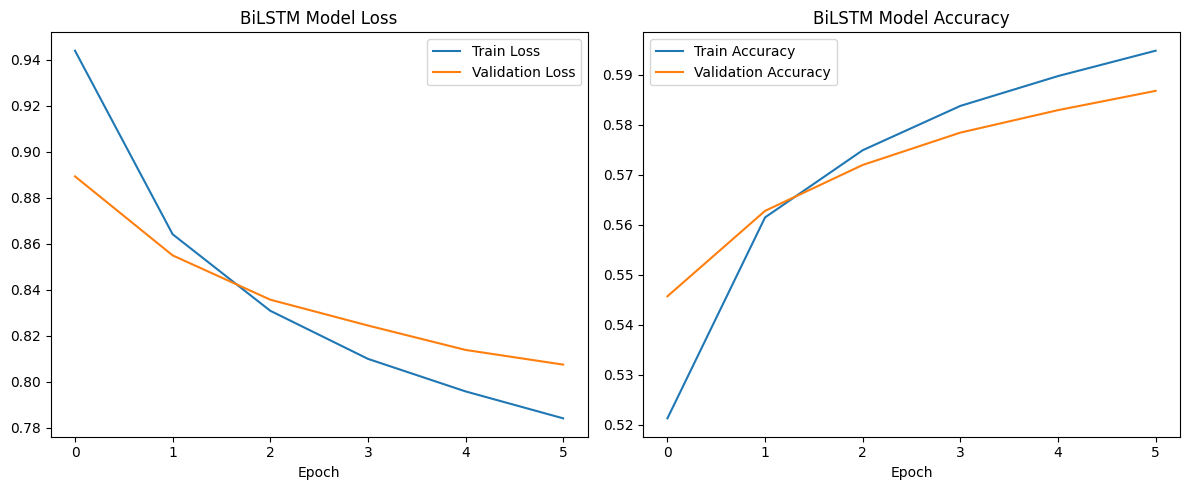

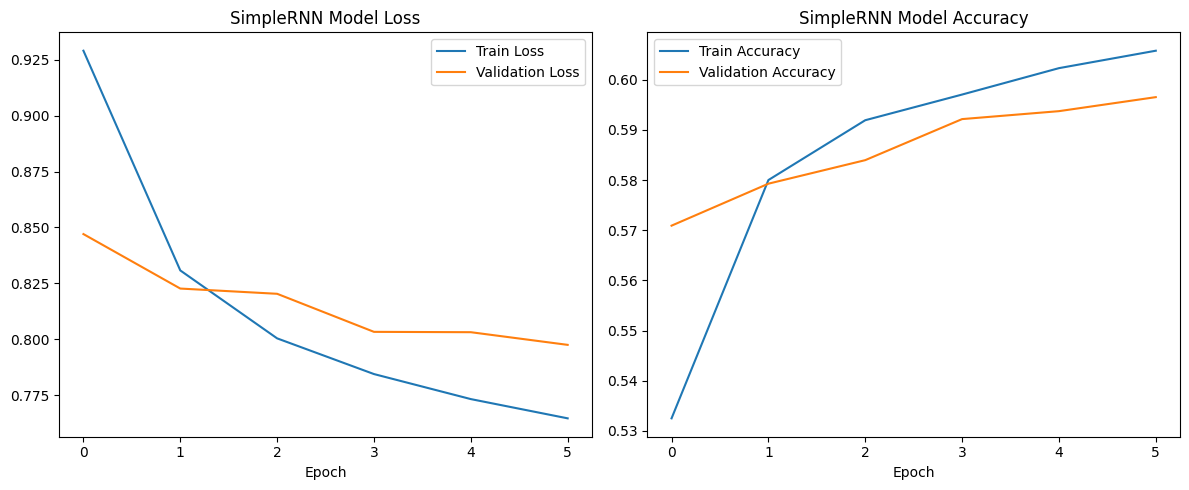

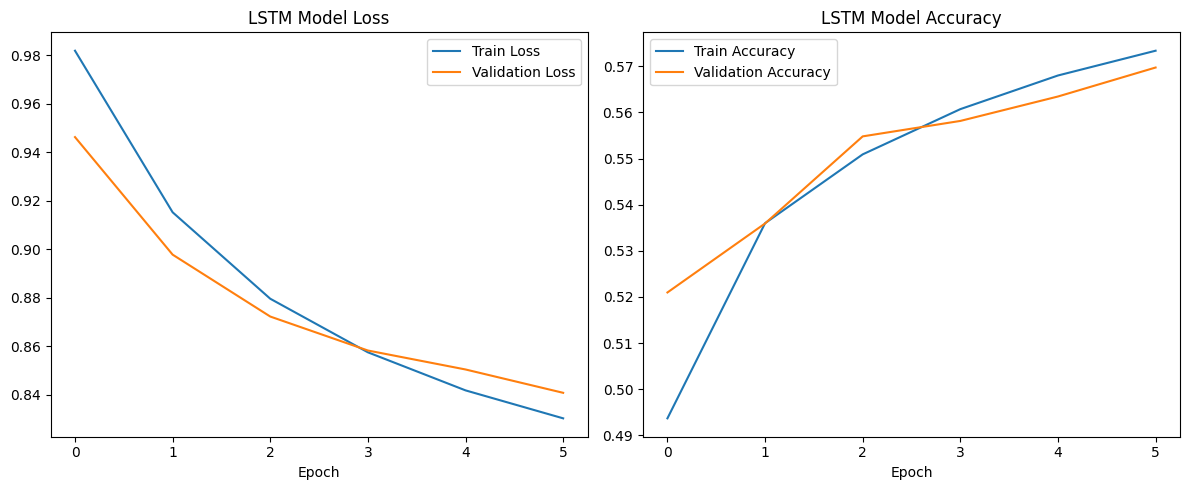

In [15]:
logs = {}
log_dir = os.path.join(OUT_DIR, "training_logs")

for csvf in os.listdir(log_dir):
    if csvf.endswith(".csv"):
        name = Path(csvf).stem.replace("training_", "")
        df_log = pd.read_csv(os.path.join(log_dir, csvf))
        logs[name] = df_log

for name, df_log in logs.items():
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df_log['loss'], label='Train Loss')
    if 'val_loss' in df_log.columns:
        plt.plot(df_log['val_loss'], label='Validation Loss')
    plt.title(f"{name} Model Loss")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    col = 'accuracy' if 'accuracy' in df_log.columns else 'acc'
    valcol = 'val_accuracy' if 'val_accuracy' in df_log.columns else 'val_acc'

    plt.plot(df_log[col], label='Train Accuracy')
    if valcol in df_log.columns:
        plt.plot(df_log[valcol], label='Validation Accuracy')

    plt.title(f"{name} Model Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()


=== MODEL PERFORMANCE SUMMARY ===


,Model Architecture,Validation Accuracy,Validation Loss,Training Time,Status
0,SimpleRNN,0.5965,0.7975,0h 1m 24s,BEST (Final Selection)
1,LSTM,0.5697,0.8408,0h 1m 55s,Tested
2,BiLSTM,0.5868,0.8074,0h 2m 37s,Tested


/tmp/ipython-input-2131145869.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model Architecture', y='val_acc', data=val_scores_df_viz, palette='Spectral')


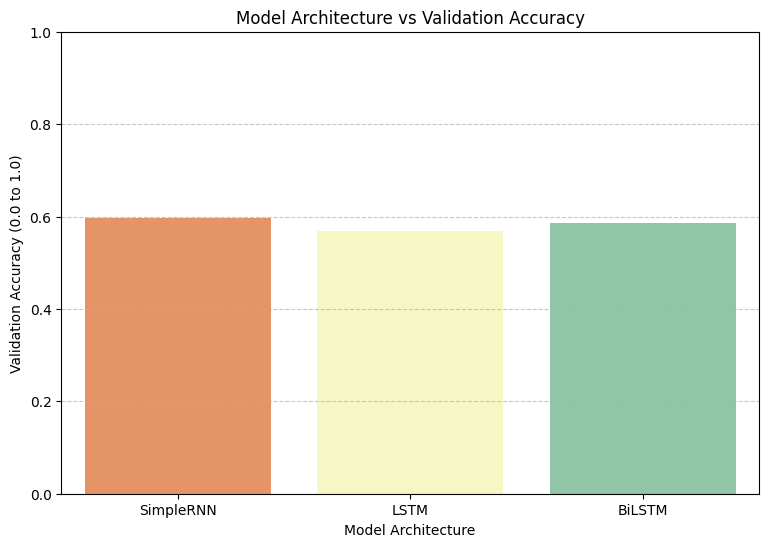

In [16]:
with open(os.path.join(OUT_DIR, "model_val_scores.json"), "r", encoding="utf-8") as f:
    val_scores = json.load(f)

def format_time(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours)}h {int(minutes)}m {int(seconds)}s"

results_data = []
best_acc = max(score['val_acc'] for score in val_scores.values())

for model_name, metrics in val_scores.items():
    results_data.append({
        "Model Architecture": model_name,
        "Validation Accuracy": f"{metrics['val_acc']:.4f}",
        "Validation Loss": f"{metrics['val_loss']:.4f}",
        "Training Time": format_time(metrics['train_time_sec']),
        "Status": "BEST (Final Selection)" if metrics['val_acc'] == best_acc else "Tested"
    })

results_df = pd.DataFrame(results_data)
print("\n=== MODEL PERFORMANCE SUMMARY ===")
display(results_df)

val_scores_df_viz = pd.DataFrame(val_scores).T.reset_index()
val_scores_df_viz.rename(columns={'index': 'Model Architecture'}, inplace=True)

plt.figure(figsize=(9,6))
sns.barplot(x='Model Architecture', y='val_acc', data=val_scores_df_viz, palette='Spectral')
plt.title("Model Architecture vs Validation Accuracy")
plt.ylabel("Validation Accuracy (0.0 to 1.0)")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

final_model = load_model(os.path.join(OUT_DIR, "best_model_project.h5"))
print(f"Loaded final model: {final_model.name}")

print("\nEvaluating on Test Set...")
test_loss, test_acc = final_model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Set Accuracy: {test_acc:.4f}, Test Set Loss: {test_loss:.4f}")

y_pred_probs = final_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
report_str = classification_report(y_true, y_pred, target_names=classes)

print("\n=== CLASSIFICATION REPORT ===")
print(report_str)

with open(os.path.join(OUT_DIR, "classification_report.json"), "w", encoding="utf-8") as f:
    json.dump(report, f, indent=4)
print(f"Classification report saved to {OUT_DIR}/classification_report.json")

def predict_sentiment(text_input):
    if 'tokenizer' not in globals():
        with open(os.path.join(OUT_DIR, 'tokenizer.json'), 'r', encoding='utf-8') as f:
            tokenizer_json = f.read()
            global tokenizer
            tokenizer = tokenizer_from_json(tokenizer_json)

    if 'label_map' not in globals():
        with open(os.path.join(OUT_DIR, "label_map.json"), "r", encoding="utf-8") as f:
            global label_map
            label_map = {int(k): v for k, v in json.load(f).items()}

    seq = tokenizer.texts_to_sequences([text_input])
    padded_seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

    probabilities = final_model.predict(padded_seq, verbose=0)[0]
    predicted_index = np.argmax(probabilities)
    predicted_label = label_map[predicted_index]

    prob_dict = {label_map[i]: float(p) for i, p in enumerate(probabilities)}

    return predicted_label, prob_dict

test_input = "The instructor's explanation was very clear and helpful."
pred_label, probs = predict_sentiment(test_input)
print("\n--- Quick Prediction Test ---")
print(f"Text: {test_input}")
print(f"Predicted Label: {pred_label}")
print(f"Probabilities: {probs}")

Loaded final model: SimpleRNN

Evaluating on Test Set...
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6002 - loss: 0.7938
Test Set Accuracy: 0.5999, Test Set Loss: 0.7935
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    negative       0.83      0.52      0.64     50278
     neutral       0.52      0.62      0.56     50279
    positive       0.57      0.66      0.61     50279

    accuracy                           0.60    150836
   macro avg       0.64      0.60      0.60    150836
weighted avg       0.64      0.60      0.60    150836

Classification report saved to /content/project_artifacts/classification_report.json

--- Quick Prediction Test ---
Text: The instructor's explanation was very clear and helpful.
Predicted Label: positive
Probabilities: {'negative': 3.889784784405492e-05, 'neutral': 0.00718672713264823, 'positive': 0.9927743673324585}


In [18]:
demo_samples = [
    "The course content was fantastic and the instructor was engaging.",
    "I hated this class, total waste of time, I learned nothing useful.",
    "The material was okay, but the labs were confusing.",
    "Absolutely brilliant teaching method and extremely clear content.",
    "The system is very slow and not user-friendly at all."
]

demo_data = []

print("\nGenerating Demo Input/Output file...")
for text in demo_samples:
    try:
        pred_label, conf_dict = predict_sentiment(text)
        confidence_score = conf_dict.get(pred_label, "N/A")

        demo_data.append({
            "Input_Text": text,
            "Predicted_Label": pred_label,
            "Confidence": f"{confidence_score:.4f}"
        })
    except Exception as e:
        print(f"Error during demo prediction for text '{text}': {e}")
        break

if demo_data:
    demo_df = pd.DataFrame(demo_data)
    demo_file_path = os.path.join(OUT_DIR, "demo_input_output.tsv")
    demo_df.to_csv(demo_file_path, sep='\t', index=False)

    print(f"Demo file saved to: {demo_file_path}")
    print("\nVerification Samples Table:")
    display(demo_df)


Generating Demo Input/Output file...
Demo file saved to: /content/project_artifacts/demo_input_output.tsv

Verification Samples Table:


,Input_Text,Predicted_Label,Confidence
0,The course content was fantastic and the instr...,neutral,0.5233
1,"I hated this class, total waste of time, I lea...",negative,0.7486
2,"The material was okay, but the labs were confu...",negative,0.6614
3,Absolutely brilliant teaching method and extre...,positive,1.0000
4,The system is very slow and not user-friendly ...,neutral,0.5588


In [20]:
print("Generating requirements.txt for reproducibility...")
!pip freeze > {os.path.join(OUT_DIR, "requirements.txt")}

checklist_content = """
NNFLL Final Project Submission Checklist:

1. best_model_project.h5 - The weights of the best performing model.
2. tokenizer.json - The tokenizer fitted on the training data.
3. label_map.json - Mapping of integers to class names.
4. classification_report.json - Detailed metrics of the final model on the test set.
5. demo_input_output.tsv - 5 sample inputs with model predictions.
6. model_val_scores.json - JSON containing validation scores and training times.
7. training_logs/*.csv - Training history logs for all models.
8. requirements.txt - Full list of Python libraries.
"""
with open(os.path.join(OUT_DIR, "SUBMISSION_CHECKLIST.txt"), "w", encoding="utf-8") as f:
    f.write(checklist_content.strip())

GROUP_IDS = "ID1_ID2_ID3"
zip_filename = f"CODE_{GROUP_IDS}"
zip_path = f"/content/{zip_filename}"

if os.path.exists(zip_path + ".zip"):
    os.remove(zip_path + ".zip")

shutil.make_archive(zip_path, 'zip', OUT_DIR)
print(f"\nSUCCESS: Project artifacts zipped to {zip_path}.zip")

Generating requirements.txt for reproducibility...

SUCCESS: Project artifacts zipped to /content/CODE_ID1_ID2_ID3.zip
